# Day 4 - Model the weak lensing signal

As this session assumes you have your own weak lensing signal so that you can model them. We understand coding up the lensing measurement part(Day 3 tutorial) is quite tedious. So, presently we will provide you the output file to use it for modelling and getting the halo mass constraits out of it. Similar to day 3 tutorials, the reader has to fill in the blanks (??) in the code snippets.  

In last tutorial/lecture, we have discussed and coded up the R.H.S. of the equation given below, which is nothing but the **observed weak lensing signal**.

$$\Delta \Sigma (R) = \frac{\sum_{ls} w_{\rm ls} e_{t,ls} (\Sigma^{-1}_{\rm crit})^{-1}}{2\mathcal{R} \sum_{ls} w_{\rm ls}}$$

Now our aim today is to predict $\Delta\Sigma(R)$, which can be expressed as -

$$\Delta\Sigma(R) \equiv \bar{\Sigma}(<R)-\langle \Sigma \rangle (R)$$

where - 

- $\bar{\Sigma}(<R)$ : average projected mass density of the matter (dark+baryon) within $R$.
- $\langle \Sigma \rangle (R)$ : azimuthally averaged projected mass (dark+baryon) density at $R$.

---

To model the $\Delta\Sigma(R)$, we need to compute the surface mass density, from the 3-dimensional model of halo mass density profile given by **Navarro–Frenk–White (NFW) profile - [arXiv:astro-ph/9508025](https://arxiv.org/abs/astro-ph/9508025)** by integrating this along the line-of-sight.
  
$$\mathbf{NFW\ profile:} \hspace{0.5 cm} \rho(r) = \frac{\rho_0}{\left(\frac{r}{r_s}\right) \left(1+\frac{r}{r_s}\right)^2}$$

$$\rho_0 = \delta_{c} \rho_{m,0} \hspace{0.2 cm} , \hspace{0.2 cm} \delta_{c} = \frac{200}{3} \frac{c^3}{\ln{(1+c)}-\frac{c}{1+c}}$$ 


If we define $r_{200m}$ to be the radius at which the average density of the halo turns out to be 200 times the present **mean matter density** of the universe, $\rho_{m,0}$, then -

$$M_{200m} = \frac{4 \pi r^3_{200m}}{3} (200\rho_{m,0})$$

$r_{200m}$ is related to the concentration parameter by, $$c = r_{200m}/r_s$$


Following [Saas-Fee lectures,](https://link.springer.com/book/10.1007/978-3-540-30310-7), this line-of-sight integrated NFW expression i.e. surface mass density, at a given projected radius **R** is given by -

$$
\begin{align*}
\Sigma(R) &= {2r_s\rho_0}\ f(r/r_s) \\
f(x) &= \frac{1}{x^2-1}(1-\mathcal{F}(x)) 
\end{align*}
$$

$$
\mathcal{F}(x) = 
\begin{cases}
\frac{{\rm acosh}(1/x)}{\sqrt{1-x^2}}, & \text{for } x \lt 1 \\
\frac{{\rm acos}(1/x)}{\sqrt{x^2-1}}, & \text{for } x \gt 1 \\
\end{cases}
$$

$$
f(x) = \frac{1}{3} \hspace{0.3 cm} , \hspace{0.3 cm}  \text{for } x = 1
$$


**Notice :** NFW profile is a spherically symmetric profile. Hence its line-of-sight (LOS) integration will be symmetric w.r.t an axis passing through the cluster centre and perpendicular to the lens plane. Hence,

$$\Sigma(R) = \langle \Sigma \rangle (R)$$

You should use the above fact while implementing the modelling.

**Notice:** We are using cluster centre as a proxy for the halo center. But there can always be some offset between them.

And the surface mass density within a projected radius, $(<R)$ is given by - 

$$
\begin{align*}
\bar{\Sigma}(<R) &= {2r_s\rho_0}\ h(r/r_s) \\
h(x) &= \frac{2}{x^2} \left[ \mathcal{F}(x) + \ln\left( \frac{x}{2} \right) \right] \\
h(1) &= 2 \left[ 1 - \ln (2) \right]
\end{align*}
$$

**Thus these expression show that the whole dark matter distribution can be parametrized in terms of only two free parameters, namely - concentration (c) and $M_{200m}$.**

**Note :** Weak gravitational lensing signal probes the total matter distribution around the lens systems (here: galaxy cluster systems). In clusters, the baryonic component only contribute dominantly in the inner regions (small projected radii), where the signal itself is very noisy, resulting in low signal-to-noise ratio. This happens because for smaller projected radii, the radial bin width becomes small due to logarithmic nature of radial binning which reduces the lens-source pair counts in such bins. Plus, the clusters are very bright in the inner regions, due to which a lot of galaxies are not identified by photometric surveys, leading to lack of sources in the inner regions. Thus these signals in the inner regions are not supposed to be very reliable. Thus we altogether ignore the baryonic contribution in the modelling of the weak lensing signals. Moreover, the inner regions don't contribute a lot in the determination of the average halo masses around the lenses.






In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

We will first define the class where we will code up all the useful function in it. We will create a class instance then use them to call these functions for model prediction. 

Here we have defined two classes one consisting of useful **constants** named constants and the **halo** class contains the functions useful for model predictions. The halo class has couple of functions define in it which are described as 

- **__init__**: Here we provide initialization parameters for the modelling - for us they are logarithm halo mass **logM200m** and concentration **con_par**. This also sets up other constants required in the other functions.

- **nfw $\rho(r)$**: This will give the standard NFW dark matter distribution for given radial bins.

- **sigma_nfw $\Sigma (R)$**: This will provide the projected NFW dark matter distribution for given radial bins.

- **avg_sigma_nfw $\bar{\Sigma}(< R)$**: This will provide the mean projected NFW dark matter distribution within the given radial bins.




**Please note that the here we are using Halo masses in units of $h^{-1}M_\odot$ and distances in units of ${\rm h^{-1}Mpc}.$**

Useful functions: [arccos](https://numpy.org/doc/stable/reference/generated/numpy.arccos.html), [arccosh](https://numpy.org/doc/stable/reference/generated/numpy.arccosh.html)

In [8]:
# working with the classes
# NFW  --> delta_sigma
class constants:
    """Useful constants"""
    G     = 4.301e-9   #km^2 Mpc M_sun^-1 s^-2 gravitational constant
    H0    = 100.       #h kms-1 Mpc-1 hubble constant at present
    omg_m = 0.315      #value of omega_matter is consistent with our signal measurement code

# Here halo class inherits the constants class 
class halo(constants):
    """Useful functions for weak lensing signal modelling"""
    
    def __init__(self, log_M200m, con_par):
        self.m_tot   = 10**log_M200m # halo Mass h-1 Msun
        self.c       = con_par       # concentration parameter
        
        self.rho_crt = 3 * self.H0**2 /(8.0*np.pi*self.G) # rho critical
        
        self.r_200   = (3 * self.m_tot /(4*np.pi*200*self.rho_crt*self.omg_m))**(1./3.) # R200m
        
        # rho_0 is numerator for NFW profile
        self.rho_0   = self.c**3 * self.m_tot/(4 * np.pi * self.r_200**3 *(np.log(1 + self.c) - self.c/(1 + self.c)))
        #print("log_M200m = %s h-1 M_sun, c = %s \n"%(np.log10(self.m_tot), self.c))
        
    def nfw(self,r):
        """given r, this gives nfw profile as per the instantiated parameters"""      
        r_s    = self.r_200/self.c
        value  = self.rho_0/((r/??)*(??+r/??)**??)
        return value
    
    def sigma_nfw(self,r):
        """analytical projection of NFW"""
        r_s = self.r_200/self.c
        k   = 2*r_s*self.rho_0
        sig = 0.0*r
        c = 0
        for i in r:
            x = i/r_s
            if x < ??:
                value = (1 - np.??(1/x)/np.sqrt(1??x**2))/(x**??-1)
            elif x > ??:
                value = (1 - np.??(1/x)/np.sqrt(x**2??1))/(x**??-1)
            else:
                value = 1./3.
            sig[c] = value*k
            c=c+1
        return sig
    
    def avg_sigma_nfw(self,r):           
        """analytical average projected of NFW"""
        r_s  = self.r_200/self.c
        k    = 2*r_s*self.rho_0
        sig  = 0.0*r
        c=0
        for i in r:
            x = i/r_s
            if x < 1:
                value = np.??cosh(1/x)/np.sqrt(1-x**??) + np.??(x/2.0) #numpy default log is base e.
                value = value*2.0/x**??
            elif x > 1:
                value = np.??cos(1/x)/np.sqrt(x**??-1)  + np.??(x/2.0)
                value = value*2.0/x**??
            else:
                value = 2*(1-np.log(2))
            sig[c] = value*k
            c=c+1
        return sig
        
    def esd(self,r): 
        """ESD profile from analytical predictions"""
        val = self.??nfw(r) - self.??nfw(r) #check with the analytical equation up there
        return val

    


<div class="alert alert-info">

Exercise: 
- Create a instance for the halo class for halo having **logM200m = 14** and **con_par = 5** as: hp = halo(14,5)     
- Tell the output of : print(np.log10(hp.m_tot), hp.c, np.log10(hp.rho_crt), hp.r_200, np.log10(hp.rho_0)) 
</div>

Text(0, 0.5, '$\\rho(r)$')

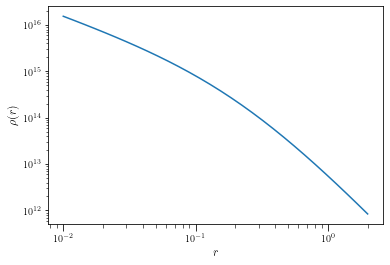

In [9]:
# nfw fits only require two parameters logarithm halo mass log10(M200m) and concentration parameter $c$
# Here we are using log10(M200m) = 14, c = 5. 
hp = halo(14,5)  # halo class instance
rbin = np.logspace(-2,np.log10(2),30)
plt.plot(rbin, hp.nfw(rbin), '-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r$')
plt.ylabel(r'$\rho(r)$')

<div class="alert alert-info">

Exercise: 
    
- Make a similar plot as above for projected matter density $\Sigma(R)$ using **sigma_nfw** and excess surface mass density $\Delta \Sigma (R)$ using **esd** function in the halo class. You can use the same radial binning as in the above code.

</div>

As we want to compare our halo mass estimates with that of the study done on same clusters but with SDSS shape catalog following - [arXiv:1707.01907](https://arxiv.org/abs/1707.01907). So, similar to this work we are also looking cluster masses in units of $10^{14} {\rm h^{-1} Mpc}$.

In [14]:
def model(x, log_M200m, c):
    log_M200m = np.log10(log_M200m) + 14 # we are looking in units of 10^14
    hp = halo(log_M200m, c);
    esd = hp.esd(x)/1e?? # remember we are working with in Mpc but the measurements are in pc, we need a conversion
    return esd


<div class="alert alert-info">

Exercise: 
    
- print the output of : print(model(np.linspace(0.2,2.0,5), 13, 6))
</div>

Now we will use the above model function to do the fitting to our measurements. At present we are using [curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) function from scipy to get the best fit model parameters. More advanced reader can use sophasticated tools like [emcee](https://emcee.readthedocs.io/) to do a MCMC on this.

In [11]:
from scipy.optimize import curve_fit

In [ ]:
data = np.loadtxt('/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/iagrg_dsigma.dat')
x    = data[:,0]
y    = data[:,1]
yerr = data[:,2]

In [ ]:
plt.figure(dpi=150)
# curve_fit requires initial guess (p0) to get resonable fits, sigma takes in the y errobars 
popt, pcov = curve_fit(model, x, y, p0=[12,0.5], sigma=yerr)

log_M200m, c = popt
sig_logMh, sig_c = np.sqrt(np.diag(pcov)) # pcov is the covariance between the parameters

# rough estimate of chisq
chisq = np.sum((y-model(x, log_M200m, c))**2*1.0/yerr**2)
dof = 10 - 2 # 10 datapoints - 2 parameters

plt.errorbar(x, y, yerr=yerr, fmt='.', capsize=3, label='Data')
plt.errorbar(x, model(x, log_M200m, c) , fmt='-', label=r'Fit, $\chi^2 /{\rm dof} = %2.2f/%d$'%(chisq,dof))

plt.title(r'$M_{\rm 200m} = %2.2f \pm %2.2f \times 10^{14} \,h^{-1} M_\odot,\, c = %2.2f \pm %2.2f$'%(log_M200m, sig_logMh, c, sig_c))
plt.legend()
plt.xlabel(r'$R[{\rm h^{-1}Mpc}]$')
plt.ylabel(r'$\Delta\Sigma [{\rm h M_\odot pc^{-2}}]$')
plt.xscale('log')
plt.yscale('log')

<div class="alert alert-info">

Exercise: 
    
- Compare your halo mass constraints with that of the weak lensing study by using SDSS shape catalog - [arXiv:1707.01907](https://arxiv.org/abs/1707.01907).
- Remember you are studying cluster with redshifts $0.1<z_{\rm red}<0.33$ and richness $55<\lambda<100$. So compare the results in the subpanel of fig 1 or fig 2 in [arXiv:1707.01907](https://arxiv.org/abs/1707.01907).    

 
</div>

Given all the machinery to the reader to get the weak lensing signal and model them to constraint halo masses. We encourage reader to try out different cuts on their cluster sample and check the variation in halo masses.

**We want to stress on the point that in the current tutorial we did a very simplistic job both in measurements as well as modelling. Please follow the references given in the tutorials as well as lectures to do a more rigorous analysis.**